In [1]:
import pyactup as pau
import random
from copy import copy
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Basic effects of Declarative Memory 

Every memory system needs to account for at least two effects: _Recency_ and _Frequency_.

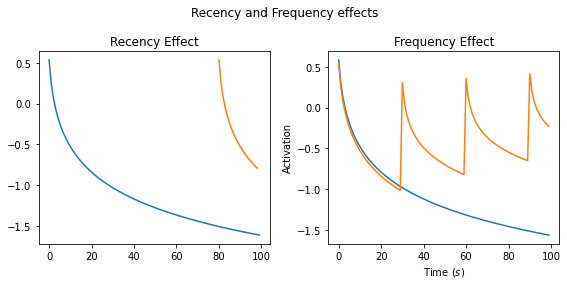

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

memory = pau.Memory()
fact = {"classname" : "PSYCH509", "instructor" : "Andrea Stocco"}
memory.learn(**fact)
curve1 = []
for i in range(100):
    if i % 100 == 0:
        memory.retrieve(**fact)
        memory.learn(advance = 1, **fact)
        #print(memory.chunks[0])
    else:
        memory.advance(1)
    curve1.append(memory.retrieve(**fact)._base_activation)

axs[0].plot(curve1)

memory = pau.Memory()
fact = {"classname" : "PSYCH509", "instructor" : "Andrea Stocco"}
#memory.learn(**fact)
curve2 = []
for i in range(100):
    if i < 80:
        curve2.append(None)
        memory.advance(1)
    elif i == 80:
        memory.learn(**fact)
        memory.learn(advance = 0.001, **fact)
    else:
        memory.advance(1)
        curve2.append(memory.retrieve(**fact)._base_activation)

axs[0].plot(curve2)
axs[0].set_title("Recency Effect")

## Frequency

memory = pau.Memory()
memory.learn(**fact)
curve1 = []
for i in range(100):
    if i % 30 == 0:
        memory.retrieve(**fact)
        memory.learn(advance = 1, **fact)
    else:
        memory.advance(1)
    curve1.append(memory.retrieve(**fact)._base_activation)


memory = pau.Memory()
memory.learn(**fact)
curve2 = []
for i in range(100):
    if i % 20 ==0 and i < 20:
        memory.retrieve(**fact)
        memory.learn(advance = 1, **fact)
    else:
        memory.advance(1)
    curve2.append(0.05 + memory.retrieve(**fact)._base_activation)

axs[1].plot(curve2)
axs[1].plot(curve1)

axs[1].set_title("Frequency Effect")

plt.suptitle("Recency and Frequency effects")
plt.xlabel("Time ($s$)")
plt.ylabel("Activation")
plt.tight_layout()
plt.savefig("figures/recency_frequency.png")
plt.show()
#plt.grid()

# Decision Making with Declarative Memory

To test this, we will use Frank's PSS task.

In [2]:
class PSS_Object():
    """A generic object for PSS task components"""
    ACTIONS = ("A", "C", "E", "F", "D", "B")
    NEG_ACTIONS = tuple("-" + x for x in ACTIONS)
    REWARD_TABLE = {"A" : 0.8, "C" : 0.7, "E" : 0.6,
                    "F" : 0.4, "D" : 0.3, "B" : 0.2}

    def is_action(self, action):
        """An action is valid only if it belongs to the list of possible actions"""
        return action[-1] in self.ACTIONS
    
    def prob_reward(self, action):
        """Returns the probability of obtaining a reward given an action"""
        if self.is_action(action):
            return self.REWARD_TABLE[action]
        
    def get_reward(self, action):
        """Return a probabilistic reward associated with an action"""
        i = random.random()
        if i <= self.prob_reward(action):
            return 1.0
        else:
            return -1.0
    
    def complement_action(self, action):
        """Returns the complement action (i.e., -A for A, and A for -A)""" 
        if self.is_action(action):
            if action.startswith("-"):
                return action[-1]
            else:
                return "-" + action
        
class PSS_State(PSS_Object):
    """
A state in the PSS object. A state is consists of two possible options
to choose from, one on the left and one on the right.
    """
    def __init__(self, options = ("A", "B")):
        """Initializes a state, with default options being (A, B)"""
        if self.is_options(options):
            self.options = options
        else:
            self.options = None
            
    @property
    def left(self):
        """The option on the left""" 
        if (self.is_options(self.options)):
            return self.options[0]
        else:
            return None
            
    
    @property
    def right(self):
        """The option on the right"""
        if (self.is_options(self.options)):
            return self.options[1]
        else:
            return None
           

    def is_options(self, options):
        """Checks whether a given tuple is a set of options"""
        if len(options) == 2 and not False in [x in self.ACTIONS for x in options]:
            return True
        else:
            return False
    
    def __eq__(self, other):
        """Equality if the options are the same, independent of order"""
        return (self.left == other.left and self.right == other.right) or \
               (self.left == other.right and self.right == other.left)
    
    def __repr__(self):
        """Represented as a tuple '(O1, O2)'"""
        return "(%s,%s)" % (self.left, self.right)
    
    def __str__(self):
        return self.__repr__()
    
    
class PSS_Decision(PSS_Object):
    """A decision made during the PSS task"""
    def __init__(self, state = None, action = None, reward = 0.0):
        self.state = state
        self.action = action
        self.reward = reward
    
    def is_state(self, state):
        """Checks if something is a valid state"""
        return isinstance(state, PSS_State)
    
    @property
    def successful(self):
        """Success if reward > 0."""
        if self.reward > 0:
            return True
        else:
            return False
    
    @property
    def optimal(self):
        """A an action was optimal if it corresponded to the highest prob option"""
        s = self.state
        apos = s.options.index(self.action)
        probs = [self.prob_reward(x) for x in s.options]
        ppos = probs.index(max(probs))
        return apos == ppos
    
    def includes_option(self, option):
        """Checks if the decision included option 'option'"""
        return option in self.state.options
    
    
    def __repr__(self):
        """The decision as a string"""
        return "<%s, %s, %0.1f>" % (self.state, self.action, self.reward)



class PSS_Task(PSS_Object):
    """An object implementing the PSS task"""
    CRITERION = {"AB" : 0.65, "CD" : 0.60, "EF" : 0.50}
    
    TRAINING_BLOCK = ((("A", "B"),) * 10 +
                      (("B", "A"),) * 10 +
                      (("C", "D"),) * 10 +
                      (("D", "C"),) * 10 +
                      (("E", "F"),) * 10 +
                      (("F", "E"),) * 10)
    
    TEST_BLOCK = ((("A", "B"),) * 2 + (("B", "A"),) * 2 +
                  (("A", "C"),) * 2 + (("C", "A"),) * 2 +
                  (("A", "D"),) * 2 + (("D", "A"),) * 2 +
                  (("A", "E"),) * 2 + (("E", "A"),) * 2 +
                  (("A", "F"),) * 2 + (("F", "A"),) * 2 +

                  (("B", "C"),) * 2 + (("C", "B"),) * 2 +
                  (("B", "D"),) * 2 + (("D", "B"),) * 2 +
                  (("B", "E"),) * 2 + (("E", "B"),) * 2 +
                  (("B", "F"),) * 2 + (("F", "B"),) * 2 +
                  
                  (("C", "D"),) * 2 + (("D", "C"),) * 2 +
                  (("C", "E"),) * 2 + (("E", "C"),) * 2 +
                  (("C", "F"),) * 2 + (("F", "C"),) * 2 +
                  
                  (("D", "E"),) * 2 + (("E", "D"),) * 2 +
                  (("D", "F"),) * 2 + (("F", "D"),) * 2 +
    
                  (("E", "F"),) * 2 + (("F", "E"),) * 2)

                  
    
    PHASES = ("Training", "Test")
    
    def __init__(self):
        """Initializes a PSS task experiment"""
        self.index = 0
        self.phase = "Training"
        
        self.train = self.instantiate_block(self.TRAINING_BLOCK)        
        self.test =  self.instantiate_block(self.TEST_BLOCK)
        self.blocks = dict(zip(self.PHASES, [self.train, self.test]))                
        self.history = dict(zip(self.PHASES, [[], []]))
        
        self.state = self.next_state()
    
    def instantiate_block(self, block):
        """Instantiates and randomizes a block of trials"""
        trials = [PSS_State(x) for x in block]
        random.shuffle(trials)
        return deque(trials)
    
    def criterion_reached(self):
        """Reached criterion for successful learning"""
        training = self.history['Training']
        if len(training) < 60:
            return False
        
        else:
            if len(training) > 60:
                training = training[-60:]
            ab = self.calculate_accuracy(training, "A")
            cd = self.calculate_accuracy(training, "C")
            ef = self.calculate_accuracy(training, "E")
            
            if ab >= self.CRITERION["AB"] and cd >= self.CRITERION["CD"] and ef >= self.CRITERION["EF"]:
                return True
            else:
                return False
    
    def next_state(self):
        """Next state (transitions are independent of actions)"""
        state_next = None
        current_block = self.blocks[self.phase]
        if len(current_block) == 0:
            if self.phase == "Training":
                if self.criterion_reached() or len(self.history["Training"]) >= 360:
                    # Move to the Test phase and recalculate the current block.
                    self.phase = "Test"
                      
                else:
                    self.blocks["Training"] = self.instantiate_block(self.TRAINING_BLOCK)
                    
                current_block = self.blocks[self.phase]
                state_next = current_block.popleft()
            
            else: 
                state_next = None # End of the experiment
        else:
            state_next = current_block.popleft()
        return state_next
                    
    
    def execute_action(self, action):
        """Executes and action and returns the new state and a reward"""
        if self.is_action(action):
            if action.startswith("-"):
                # This handles the cases where an agent chooses NOT
                # to pick a specific action (as in the BG models)
                action = [x for x in self.state.options if x is not action[-1]][0]
            
            r = None
            if self.phase == "Training":
                r = self.get_reward(action)
            
            # Update history
            d = PSS_Decision(self.state, action, reward = r)
            self.history[self.phase].append(d)
            
            self.state = self.next_state()
            return (self.state, r)
    
    def calculate_accuracy(self, decisions, option, exclude = "None"):
        """Calculates accuracy across all decisions that include option 'option' but not option 'exclude'"""
        opt = [x.optimal for x in decisions if x.includes_option(option) and not x.includes_option(exclude)]
        return np.mean(opt)
        
    def accuracies(self):
        """Returns the Choose / Avoid accuracies"""
        test = self.history["Test"]
        if len(test) >= 60:
            return (self.calculate_accuracy(test, option = 'A', exclude = 'B'),
                    self.calculate_accuracy(test, option = 'B', exclude = 'A'))
            

Now we need to define a few functions to choose.

In [3]:
class DMAgent():
    """A declarative memory agent"""
    def __init__(self, nsamples=3):
        """Initializes an agent"""
        self.memory = pau.Memory()
        self.nsamples = nsamples
        self.init_memory()
        
    def init_memory(self):
        """Initializes the agent with some fake memories (to make the first choice possible)"""
        dm = self.memory
        dm.learn(action="A", reward=-1)
        dm.learn(action="B", reward=-1)
        dm.learn(action="C", reward=-1)
        dm.learn(action="D", reward=-1)
        dm.learn(action="E", reward=-1)
        dm.learn(action="F", reward=-1)
    
    def evaluate(self, option):
        """Evaluates an option by sampling from memory"""
        res = []
        dm = self.memory
        for i in range(self.nsamples):
            instance = dm.retrieve(action = option)
            res.append(instance["reward"])
        return np.sum(res)
    
    def choose(self, state):
        """Choose an option"""               
        val1, val2 = [self.evaluate(option) for option in [state.left, state.right]]
        if val1 > val2:
            return state.left
        elif val1 < val2:
            return state.right
        else:
            return random.choice([state.left, state.right])
                       
def PSS_loop(agent, task):
    while task.state is not None:
        state1 = task.state
        choice = agent.choose(state1)
        state2, reward1 = task.execute_action(choice)
        if reward1 is not None:
            agent.memory.learn(action = choice, reward = reward1)
        agent.memory.advance(1)
    
def plot_results(results, param_values):
    x = [1,2]   # X axis
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin = 0, vmax = (len(param_values) - 1))
    scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

    fig, ax = plt.subplots()

    for i in range(len(param_values)):
        p = param_values[i]
        colorVal = scalarMap.to_rgba(i)
        ax.plot(x, results[p], "o-", color=colorVal)
    
    ax.axis([0.75, 2.25, 0.48, 0.95])
    ax.set_ylabel("Mean Accuracy")
    ax.set_xticks([1,2])
    ax.set_xticklabels(["Choose", "Avoid"])
    #fig.colorbar(ax, param_values)
    plt.legend(["N = %.2f" % x for x in param_values], loc="best", ncol=2)

Let's do a simple test:

In [4]:
agent = DMAgent()
task = PSS_Task()
PSS_loop(agent, task)
task.accuracies()

(0.9375, 0.875)

And let's inspect the model's memories:

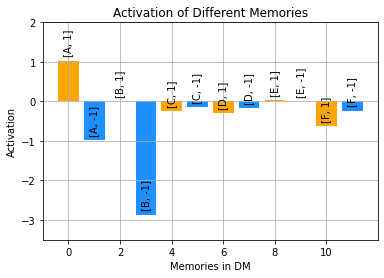

In [5]:
A = []
fig, ax = plt.subplots(1, 1)
labels=[]
for action in "ABCDEF":
    for reward in (1, -1):
        labels.append("[%s, %d]" % (action, reward))
        chunk = agent.memory.retrieve(action = action, reward = reward)
        if chunk is not None:
            A.append(chunk._base_activation)
        else:
            A.append(0)
ax.bar(range(len(labels)), height=A, color=["orange", "dodgerblue"]*6)
ax.set_title("Activation of Different Memories")
ax.set_ylabel("Activation")
ax.set_xlabel("Memories in DM")
ax.set_ylim(-3.5, 2)
       
for i in range(len(labels)):
    ax.text(i, A[i] + 0.1, labels[i], ha="center", va="bottom", rotation="vertical")
plt.grid()
plt.savefig("figures/pss_memory_activation.png")

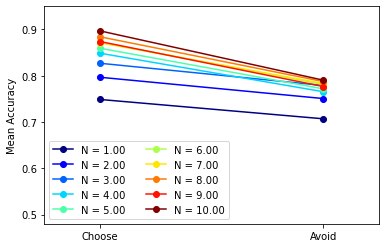

In [6]:
results = {}
for n in range(1, 11):
    performance = []
    for i in range( 250 ):
        task = PSS_Task()
        agent = DMAgent(nsamples = n)
        PSS_loop(agent, task)
        performance.append(task.accuracies())

    results[n] = (np.mean([x[0] for x in performance]), np.mean([x[1] for x in performance]))

plot_results(results, list(range(1, 11)))
plt.savefig("figures/decision_by_sampling.png")
plt.show()

## Instance-based Learning

We can now generalize this approach to complex tasks using the Instance-Based Learning (IBL) framework. In IBL, _instances_ are memorized as episodic memories of the form [_state_, _decision_, _utility_] (_SDU_).

We will apply this framework to the RL problem of navigating a maze.

In [7]:
class Maze():
    """A maze environment"""

    ACTIONS = ("up", "down", "left", "right") # List of actions
    INITIAL_STATE = (0, 0) # Always starts at the topleft corner
    
    def __init__(self, fname = "grid.txt"):
        """Inits a maze by loading the grid file"""
        self.grid = np.loadtxt(fname)
        self.state = self.INITIAL_STATE
        self.end = False


    def state_transition(self, state1, action1):
        "Defines the next state gien the "
        x, y = state1
        
        # If we have reached the cheese, we transition 
        # to the terminal state
        if self.grid[x, y] > 0:
            return None
        
        # Otherwise, we update the position
        state2 = copy(state1)
        
        if action1 in self.ACTIONS:
            if action1 == "up":
                if x > 0:
                    state2 = (x - 1, y)
            
            elif action1 == "left":
                if y > 0:
                    state2 = (x, y - 1)
            
            elif action1 == "down":
                if x < (self.grid.shape[0] - 1):
                    state2 = (x + 1, y)

            elif action1 == "right":
                if y < (self.grid.shape[1] - 1):
                    state2 = (x, y + 1)
                    
        return state2
                    
    
    def reward_transition(self, state1, action1, state2):
        """Reward is -1 for bouncing against the walls, and whatever is on the grid otherwise"""
        #if state1 == state2:
        #    return -1
        if state2 == None:
            return 0
        else:
            return self.grid[state2[0], state2[1]]
        
    
    # Quick way to combine State transitions and Reward transitions 
    def transition(self, action1):
        """Changes the state following an action"""
        state1 = self.state
        state2 = self.state_transition(state1, action1)
        reward2 = self.reward_transition(state1, action1, state2)
        
        self.state = state2
        return (state2, reward2) # Returns s_t+1, r_t+1

    
    def print_state(self):
        "Prints a text representation of the maze (with the agent position)"
        bar = "-" * ( 4 * self.grid.shape[1] + 1)
        for i in range(self.grid.shape[0]):
            row = "|"
            for j in range(self.grid.shape[1]):
                cell = " "
                if i == self.state[0] and j == self.state[1]:
                    cell = "*"
                row += (" %s |" % cell)
            print(bar)
            print(row)
        print(bar)

And here is the code for our IBL-based agent

In [8]:
class IBLAgent():
    """A instance-based learning agent"""
    def __init__(self):
        """Initializes an agent"""
        self.actions = ("up", "left", "down", "right")
        self.memory = pau.Memory()
        self.init_memory()
        
    def init_memory(self):
        """Initializes the agent with some preliminary SDUs (to make the first choice possible)"""
        dm = self.memory
        for i in range(4):
            for j in range(4):
                state = "<%d-%d>" % (i, j)
                for action in self.actions:
                    dm.learn(state = state, decision = action, utility = -1)
                
    
    def evaluate(self, state, option):
        """Evaluates an option by sampling from memory"""
        res = []
        dm = self.memory
        return dm.blend("utility", state = state, decision = option)
    
    def choose(self, state):
        """Choose an option"""        
        actions = list(self.actions)
        random.shuffle(actions)
        vals = [self.evaluate(state, x) for x in actions]
        min_val = np.min(vals)
        V = dict(zip(actions, vals))
        best_actions = [x for x in actions if V[x] == min_val]
        return random.choice(best_actions)
    
def maze_run(agent, maze):
    while maze.state is not None:
        state1 = "<%d-%d>" % maze.state
        choice = agent.choose(state1)
        state2, reward1 = maze.transition(choice)
        
        if state2 is not None:
            state2 = "<%d-%d>" % state2
        
            if reward1 <= 0:
                # Use Value of state2
                utility = np.max([agent.memory.blend("utility", state = state2, decision = x) for x in agent.actions])
            else:
                utility = reward1
        
            agent.memory.learn(state = state1, decision = choice, utility = utility)
            agent.memory.advance(1)
        
def run_trials(agent, maze, n):
    for i in range(n):
        maze.state = Maze.INITIAL_STATE
        maze_run(agent, maze)
        
 

Now, we can visualize what the agent has learned about the utlity of performing any given action in a particular position of the maze.  

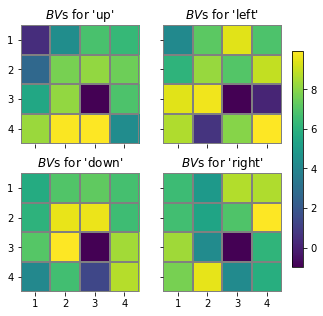

In [21]:
maze = Maze()
agent = IBLAgent()
maze_run(agent, maze)
run_trials(agent, maze, 8)

def plot_ibl_tables(agent, **kwargs):
    """Visualizes the Q tables, one per action"""
    fig, axs = plt.subplots(2, 2, figsize=(5,5))
    #i = 0
    for i, a in enumerate(agent.actions):
        # Create the corresponding state table
        data = np.zeros((4,4))
            
        for j in range(4):
            for k in range(4):
                state = "<%d-%d>" % (j, k)
                data[j, k] = agent.memory.blend("utility", state = state, decision = a)  
                
        # Plot the heatmap
        im = axs.flat[i].imshow(data, **kwargs, cmap="viridis")

        # We want to show all ticks...
        axs.flat[i].set_xticks(np.arange(data.shape[1]))
        axs.flat[i].set_yticks(np.arange(data.shape[0]))
        axs.flat[i].set_xticklabels(range(1,5))
        axs.flat[i].set_yticklabels(range(1,5))

        # Let the horizontal axes labeling appear on top.
        axs.flat[i].tick_params(top=False, bottom=True,
                                labeltop=False, labelbottom=True)

        # Turn spines off and create white grid.
        for edge, spine in axs.flat[i].spines.items():
            spine.set_visible(False)

        axs.flat[i].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        axs.flat[i].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        axs.flat[i].grid(which="minor", color="grey", linestyle='-', linewidth=2)
        axs.flat[i].tick_params(which="minor", bottom=False, left=False)
        axs.flat[i].set_title(r"$BV$s for '%s'" % (a,))

        #i += 1
    
    for ax in axs.flat:
        ax.label_outer()

    fig.subplots_adjust(right=0.85, hspace=0.2)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    #fig.tight_layout()

plot_ibl_tables(agent)
plt.savefig("figures/blended_values_tables.png")
plt.show()

Note the generality of IBL. Because of blending, it is absolutely possible to obtain blended values for _states_ as well as _actions_. In fact, it is possible to naturally represent states and actions in continuous form

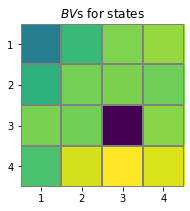

In [106]:
def plot_ibl_state(agent, **kwargs):
    """Visualizes the V table"""
    fig, axs = plt.subplots(1, 1, figsize=(3,3))
    data = np.zeros((4,4))
            
    for j in range(4):
        for k in range(4):
            state = "<%d-%d>" % (j, k)
            data[j, k] = agent.memory.blend("utility", state = state)  
                
    # Plot the heatmap
    im = axs.imshow(data, **kwargs, cmap="viridis")

    # We want to show all ticks...
    axs.set_xticks(np.arange(data.shape[1]))
    axs.set_yticks(np.arange(data.shape[0]))
    axs.set_xticklabels(range(1,5))
    axs.set_yticklabels(range(1,5))

    # Let the horizontal axes labeling appear on top.
    axs.tick_params(top=False, bottom=True,
                                labeltop=False, labelbottom=True)

    # Turn spines off and create white grid.
    for edge, spine in axs.spines.items():
        spine.set_visible(False)

    axs.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    axs.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    axs.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    axs.tick_params(which="minor", bottom=False, left=False)
    axs.set_title(r"$BV$s for states")

#cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
#fig.colorbar(im, cax=cbar_ax)
#fig.tight_layout()

plot_ibl_state(agent)
plt.savefig("blended_values_states.png")
plt.show()